Okay, I've now fixed the time issue. Let's see where the largest errors are now.

**Edit:** There seem to be 2 issues:
- context isn't exactly equal (error ~ `0.0005`)
- applying ctrl subblock in step 23 makes the error jump (from `0.0001` to `0.2075`). This might be due to the above context issue.

**Edit 2:**
The difference in text encodings between cuda diffusers and cuda Heidelberg is split in 2 parts:
1. `cuda diffusers` and `cuda Heidelberg w/o mixed precision`: **no** difference; exactly equal
2. `cuda diffusers w/o mixed precision` and `cuda Heidelberg w/ mixed precision`: **all** the difference, ie ~ `0.0005`

In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200, precision=3, sci_mode=False)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Compare intermediate results

In [3]:
from util_inspect import load_intermediate_outputs, print_metadata, compare_intermediate_results

In [4]:
# intermediate outputs from Heidelberg code run on cuda
model_outp_cloud = load_intermediate_outputs('intermediate_output/cloud_debug_log.pkl')
# intermediate outputs from diffusers code run on cuda
model_outp_local = load_intermediate_outputs('intermediate_output/cuda_diffusers_debug_log.pkl') # local_debug_log
len(model_outp_cloud),len(model_outp_local)

(72, 72)

In [5]:
model_outp_cloud[1].shape, model_outp_local[1].shape

([2, 1280], [2, 1280])

In [6]:
temb_c = model_outp_cloud[1].t
temb_l = model_outp_local[1].t
temb_c.shape, temb_l.shape

(torch.Size([2, 1280]), torch.Size([2, 1280]))

In [7]:
compare_intermediate_results(model_outp_cloud, model_outp_local, n=8+8*4,prec=4, compare_prec=3)

-  | cloud               | local               | equal name? | equal shape? | equal values? | mean abs Δ
   |                     |                     |             |              |    prec=3     |    prec=4
-------------------------------------------------------------------------------------------------------
0  | prep   x            | prep   x            |      y      |      y       |       y       |    0.0000
1  | prep   temb         | prep   temb         |      y      |      y       |       y       |    0.0000
2  | prep   context      | prep   context      |      y      |      y       |       n       |    0.0005
3  | prep   raw hint     | prep   raw hint     |      y      |      y       |       y       |    0.0000
4  | prep   guided_hint  | prep   guided_hint  |      y      |      y       |       y       |    0.0000
-------------------------------------------------------------------------------------------------------
5  | enc    h_base       | enc    h_base       |      y      | 

Let's look at the values of context

In [8]:
cxt_c,cxt_l = model_outp_cloud[2].t,model_outp_local[2].t

cxt_c_neg,cxt_c_pos = cxt_c
cxt_l_neg,cxt_l_pos = cxt_l

cxts = (cxt_c_neg, cxt_c_pos, cxt_l_neg, cxt_l_pos)
cxt_names= 'cxt_c_neg cxt_c_pos cxt_l_neg cxt_l_pos'.split(' ')

for t,n in zip(cxts, cxt_names):
    print(n,t.shape)

cxt_c_neg torch.Size([77, 2048])
cxt_c_pos torch.Size([77, 2048])
cxt_l_neg torch.Size([77, 2048])
cxt_l_pos torch.Size([77, 2048])


In [9]:
print(f'{"name":<10}{"head":<89}{"tail":<89}')
for t,n in zip(cxts, cxt_names):
    print(n,t.flatten()[:10],t.flatten()[:-10])

name      head                                                                                     tail                                                                                     
cxt_c_neg tensor([-3.892, -2.511,  4.718,  1.092, -1.341, -4.955, -2.133, -2.663,  3.388,  0.525]) tensor([-3.892, -2.511,  4.718,  ..., -0.050,  0.448, -0.180])
cxt_c_pos tensor([-3.892, -2.511,  4.718,  1.092, -1.341, -4.955, -2.133, -2.663,  3.388,  0.525]) tensor([-3.892, -2.511,  4.718,  ...,  0.081,  0.510,  0.020])
cxt_l_neg tensor([-3.892, -2.511,  4.717,  1.092, -1.341, -4.957, -2.133, -2.664,  3.387,  0.525]) tensor([-3.892, -2.511,  4.717,  ..., -0.051,  0.448, -0.181])
cxt_l_pos tensor([-3.892, -2.511,  4.717,  1.092, -1.341, -4.957, -2.133, -2.664,  3.387,  0.525]) tensor([-3.892, -2.511,  4.717,  ...,  0.080,  0.509,  0.020])


Interestingly, the positive and negative text embeds look similar at the beginning. But they are of course very different, as they represent the positive and negative prompt respectively.

In [10]:
(cxt_c_neg-cxt_c_pos).abs().mean(), (cxt_l_neg-cxt_l_pos).abs().mean()

(tensor(0.456), tensor(0.456))

The contexts look almost indentical when compared across cloud/local

In [11]:
torch.set_printoptions(linewidth=200, precision=4, sci_mode=False)

In [12]:
(cxt_c_neg-cxt_l_neg).abs().mean(), (cxt_c_pos-cxt_l_pos).abs().mean()

(tensor(0.0005), tensor(0.0006))

Both the negative and positive text embeddings differ approx. `0.0005` across local/cloud. (Remember 'local' means `cuda diffusers`, `cloud` means `cuda Heidelberg`)

## Analyze difference after application of `m_ctrl`

In [13]:
torch.set_printoptions(linewidth=200, precision=3, sci_mode=False)

In [14]:
import pickle

with open('intermediate_output/subblock-minus-1/cloud_detailled_debug_log.pkl', 'rb') as f:
    dlog_c = pickle.load(f)
with open('intermediate_output/subblock-minus-1/cuda_diffusers_detailled_debug_log.pkl', 'rb') as f:
    dlog_l = pickle.load(f)

In [15]:
for name, t in dlog_l:
    print(f'{name:<20}{str(list(t.shape)):<20}{t.flatten()[:10]}')

conv1               [2, 32, 96, 96]     tensor([-0.828, -0.465, -0.597, -0.728, -0.992,  0.050, -0.500, -1.920, -1.507, -0.325])
add time_emb_proj   [2, 32, 96, 96]     tensor([-0.418, -0.055, -0.187, -0.318, -0.582,  0.460, -0.090, -1.510, -1.097,  0.085])
conv2               [2, 32, 96, 96]     tensor([-0.201, -0.217, -0.178, -0.103, -0.235, -0.112, -0.033,  0.107, -0.073, -0.313])
add conv_shortcut   [2, 32, 96, 96]     tensor([-0.579, -0.396, -0.193, -0.662, -0.056, -0.110, -0.406,  0.084, -0.649, -1.122])
conv1               [2, 32, 96, 96]     tensor([-0.489, -1.452, -1.598, -1.579, -1.935, -1.825, -2.010, -1.613, -1.147, -1.336])
add time_emb_proj   [2, 32, 96, 96]     tensor([ 0.798, -0.165, -0.311, -0.291, -0.648, -0.538, -0.723, -0.326,  0.140, -0.049])
conv2               [2, 32, 96, 96]     tensor([-0.109, -0.187,  0.009, -0.117,  0.200, -0.034,  0.062,  0.047,  0.089, -0.130])
add conv_shortcut   [2, 32, 96, 96]     tensor([-0.586, -0.251,  0.140, -0.243,  0.251, -0.865, -

Local intermediate results are not empty

In [16]:
for name, t in dlog_c:
    print(f'{name:<20}{str(list(t.shape)):<20}{t.flatten()[:10]}')

conv1               [2, 32, 96, 96]     tensor([-0.828, -0.465, -0.597, -0.728, -0.992,  0.050, -0.500, -1.920, -1.507, -0.325])
add time_emb_proj   [2, 32, 96, 96]     tensor([-0.418, -0.055, -0.187, -0.318, -0.582,  0.460, -0.090, -1.510, -1.097,  0.085])
conv2               [2, 32, 96, 96]     tensor([-0.201, -0.217, -0.178, -0.103, -0.235, -0.112, -0.033,  0.107, -0.073, -0.313])
add conv_shortcut   [2, 32, 96, 96]     tensor([-0.579, -0.396, -0.193, -0.662, -0.056, -0.110, -0.406,  0.084, -0.649, -1.122])
conv1               [2, 32, 96, 96]     tensor([-0.489, -1.452, -1.598, -1.578, -1.935, -1.825, -2.010, -1.613, -1.147, -1.336])
add time_emb_proj   [2, 32, 96, 96]     tensor([ 0.798, -0.165, -0.311, -0.291, -0.648, -0.538, -0.723, -0.326,  0.140, -0.049])
conv2               [2, 32, 96, 96]     tensor([-0.109, -0.187,  0.009, -0.117,  0.200, -0.033,  0.062,  0.047,  0.089, -0.130])
add conv_shortcut   [2, 32, 96, 96]     tensor([-0.586, -0.251,  0.140, -0.243,  0.251, -0.865, -

Cloud intermediate results are also not empty

___

Okay, now let's compare local and cloud intermediate outputs (at level subblock minus 1):

In [17]:
from functools import partial
from util_inspect import fmt_bool

def compare_intermediate_results(n=None,n_start=0,prec=5, compare_prec=2):
    if n is None: n=max(len(dlog_c),len(dlog_l))
    i,lv,b,c,l,en,es,ev,d,stats = '-','level','block','cloud','local','equal name?','equal shape?','equal values?','mean abs Δ','mean ± std'
    print(f'{i:<3} | {lv:<5} | {b:<5} | {c:<19} | {l:<19} | {en:<11} | {es:<12} | {ev:<13} | ' + ('{:>'+str(prec+5)+'}').format(d) + f' | {stats:>12}')
    i,lv,b,c,l,en,es,ev,d,stats = '','','','','','','','prec='+str(compare_prec),'prec='+str(prec),''
    print(f'{i:<3} | {lv:<5} | {b:<5} | {c:<19} | {l:<19} | {en:<11} | {es:<12} | {ev:^13} | ' + ('{:>'+str(prec+5)+'}').format(d) + f' | {stats:>12}')
    total_len = 3+3+5+3+5+3+19+3+19+3+11+3+12+3+13+3+(prec+5)+3+12

    line = partial(
        lambda txt, width: print(txt * (width//len(txt))),
        width=total_len
    )
    
    line('=')

    lv,block=1,1
    for i in range(n_start,n):
        (cn,ct),(ln,lt)=dlog_c[i],dlog_l[i]
        eq_name = cn==ln
        eq_shape = ct.shape==lt.shape
        eq_vals = torch.allclose(ct,lt,atol=10**-compare_prec)
        #ct,lt = broadcast(c.t,l.t)
        mae = (ct-lt).abs().mean()

        mean,std = ct.mean(),ct.std()
        
        print(f'{i:<3} | {lv:^5} | {block:^5} | {cn:<19} | {ln:<19} | ', end='')
        print(fmt_bool(eq_name, '^11')+' | '+fmt_bool(eq_shape, '^12')+' | '+fmt_bool(eq_vals, '^13')+' | ', end='')
        print(('{:>'+str(prec+5)+'.'+str(prec)+'f}').format(mae)+' | ', end='')
        print(f'{ct.mean():>5.2f} ± {ct.std():>3.2f}')

        if cn=='conv':
            line('=')
            lv += 1
            block = 1
        if cn in ('add conv_shortcut','proj_out'):
            line('-')
            block += 1
        if cn in ('proj_in', 'add ff'): line('-   ')

As I can see below, large errors are introduced in `attn2`. This is be consistent with the finding that there's an error in `context`. (Remember, `attn1` is the self-attention, while `attn2` is the cross-attention, ie the part where `context` is used.)

In [18]:
compare_intermediate_results()

-   | level | block | cloud               | local               | equal name? | equal shape? | equal values? | mean abs Δ |   mean ± std
    |       |       |                     |                     |             |              |    prec=2     |     prec=5 |             
0   |   1   |   1   | conv1               | conv1               |      y      |      y       |       y       |    0.00004 | -0.39 ± 1.27
1   |   1   |   1   | add time_emb_proj   | add time_emb_proj   |      y      |      y       |       y       |    0.00004 | -0.26 ± 1.49
2   |   1   |   1   | conv2               | conv2               |      y      |      y       |       y       |    0.00002 | -0.03 ± 0.41
3   |   1   |   1   | add conv_shortcut   | add conv_shortcut   |      y      |      y       |       y       |    0.00002 |  0.00 ± 0.99
----------------------------------------------------------------------------------------------------------------------------------------
4   |   1   |   2   | conv1              

## Let's load the model to manually create the context

In [19]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [20]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)
cnxs.base_model = sdxl_pipe.unet

The example script of Heidelberg manually sets scale_list to 0.95

In [21]:
cnxs.scale_list = cnxs.scale_list * 0. + 0.95
assert cnxs.scale_list[0] == .95

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [22]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...


In [23]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

In [24]:
import torch
import random
import numpy as np

def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

RANDOM_SEED_IN_PAPER = 1999158951

In [25]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

In [26]:
from util import cls_name

In [27]:
cls_name(cnxs_pipe.tokenizer), cls_name(cnxs_pipe.tokenizer_2), cls_name(cnxs_pipe.text_encoder), cls_name(cnxs_pipe.text_encoder_2)

('CLIPTokenizer',
 'CLIPTokenizer',
 'CLIPTextModel',
 'CLIPTextModelWithProjection')

In [28]:
cnxs_pipe.text_encoder_2

CLIPTextModelWithProjection(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1280)
      (position_embedding): Embedding(77, 1280)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-31): 32 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (layer_norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1280, out_features=5120, bias=True)
            (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          )
          (layer_norm2): La

Steps to do manually:
1. Tokenize
2. Embedd: Tokens, Positions
3. Apply ResBlocks
4. Apply LayerNorm
5. Apply Projection

In [29]:
my_toks = cnxs_pipe.tokenizer_2(prompt, padding="max_length", max_length=cnxs_pipe.tokenizer_2.model_max_length, truncation=True, return_tensors="pt",).input_ids
my_toks = my_toks.to(device)
print(my_toks.shape)
my_toks

torch.Size([1, 77])


tensor([[49406, 25602,   267,  7342,   530,   518,  6058,   267,  1105,   633,  6480,   267,  1153, 16157,  7342,   267,  5302, 12609, 49407,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0]], device='cuda:0')

In [30]:
my_pos = torch.arange(cnxs_pipe.tokenizer_2.model_max_length).reshape(1,-1).to(device)
print(my_pos.shape)
my_pos

torch.Size([1, 77])


tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]], device='cuda:0')

In [31]:
my_tok_embedder = cnxs_pipe.text_encoder_2.text_model.embeddings.token_embedding
my_pos_embedder = cnxs_pipe.text_encoder_2.text_model.embeddings.position_embedding

my_overall_embedder = cnxs_pipe.text_encoder_2.text_model.embeddings

In [32]:
my_toks_embs = my_tok_embedder(my_toks)
my_pos_embs = my_pos_embedder(my_pos)

my_overall_embs = my_toks_embs + my_pos_embs

In [33]:
my_toks_embs.shape, my_pos_embs.shape, my_overall_embs.shape

(torch.Size([1, 77, 1280]),
 torch.Size([1, 77, 1280]),
 torch.Size([1, 77, 1280]))

In [34]:
my_embs = my_overall_embedder(input_ids=my_toks, position_ids=None)

In [35]:
assert (my_embs==my_overall_embs).all()

In [36]:
my_text_encoder    = cnxs_pipe.text_encoder_2.text_model.encoder
my_final_layer_norm= cnxs_pipe.text_encoder_2.text_model.final_layer_norm
my_text_projection = cnxs_pipe.text_encoder_2.text_projection

In [37]:
my_text_encoder

CLIPEncoder(
  (layers): ModuleList(
    (0-31): 32 x CLIPEncoderLayer(
      (self_attn): CLIPAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (layer_norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (mlp): CLIPMLP(
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      )
      (layer_norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [38]:
my_final_layer_norm

LayerNorm((1280,), eps=1e-05, elementwise_affine=True)

In [39]:
my_text_projection

Linear(in_features=1280, out_features=1280, bias=False)

In [40]:
after_txt_encoder = my_text_encoder(my_embs)[0]
after_txt_encoder.shape

torch.Size([1, 77, 1280])

In [41]:
after_final_norm = my_final_layer_norm(after_txt_encoder)
after_final_norm.shape

torch.Size([1, 77, 1280])

In [42]:
after_text_projection = my_text_projection(after_final_norm)
after_text_projection.shape

torch.Size([1, 77, 1280])

**Edit:** The shapes are wrong. They should be `[1, 77, 2048]`. I have computed the text info which is infused into the time info. But I am interested in the text info which is used in the cross-attentions. 😤

For reference, this is the automated comutation result: `cxt_l_pos tensor`  =`[-3.892, -2.511,  4.717,  ...,  0.080,  0.509,  0.020]`

**Q: These are not the same.** What am I missing?<br/>
**Edit: A:** I computed the wrong text info (the one to add to time info, which has shape `[1,1280]`), but I want the text info which is used in cross-attn, which has shape `[1,77,2048]`

In [43]:
my_toks_1 = cnxs_pipe.tokenizer  (prompt, padding="max_length", max_length=cnxs_pipe.tokenizer  .model_max_length, truncation=True, return_tensors="pt",).input_ids.to(device)
my_toks_2 = cnxs_pipe.tokenizer_2(prompt, padding="max_length", max_length=cnxs_pipe.tokenizer_2.model_max_length, truncation=True, return_tensors="pt",).input_ids.to(device)
print(my_toks_1.shape, my_toks_2.shape)
print('--')
print(my_toks_1)
print('--')
print(my_toks_2)

torch.Size([1, 77]) torch.Size([1, 77])
--
tensor([[49406, 25602,   267,  7342,   530,   518,  6058,   267,  1105,   633,  6480,   267,  1153, 16157,  7342,   267,  5302, 12609, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]], device='cuda:0')
--
tensor([[49406, 25602,   267,  7342,   530,   518,  6058,   267,  1105,   633,  6480,   267,  1153, 16157,  7342,   267,  5302, 12609, 49407,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,  

In [44]:
my_embedder_1 = cnxs_pipe.text_encoder  .text_model.embeddings
my_embedder_2 = cnxs_pipe.text_encoder_2.text_model.embeddings

my_encoder_1  = cnxs_pipe.text_encoder  .text_model.encoder
my_encoder_2  = cnxs_pipe.text_encoder_2.text_model.encoder

In [45]:
my_embs_1 = my_embedder_1(input_ids=my_toks_1, position_ids=None)
my_embs_2 = my_embedder_2(input_ids=my_toks_2, position_ids=None)

my_embs_1.shape, my_embs_2.shape

(torch.Size([1, 77, 768]), torch.Size([1, 77, 1280]))

In [46]:
my_enc_output_1 = my_encoder_1(my_embs_1, output_hidden_states=True).hidden_states[-2]
my_enc_output_2 = my_encoder_2(my_embs_2, output_hidden_states=True).hidden_states[-2]

In [47]:
print(my_enc_output_1.flatten()[:10])
print(my_enc_output_2.flatten()[:10])

tensor([-1.316, -1.622,  0.167,  0.744, -0.009, -2.923, -0.033, -2.071,  2.039,  0.766], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.009, -0.479,  0.406,  0.079,  0.342,  0.089, -0.504,  0.058, -0.030,  0.223], device='cuda:0', grad_fn=<SliceBackward0>)


In [48]:
my_total_enc_output = torch.concat([my_enc_output_1, my_enc_output_2], dim=-1)
my_total_enc_output.shape

torch.Size([1, 77, 2048])

So, this is my manual computation of `cxt_c_pos`:

In [49]:
print(my_total_enc_output.flatten()[:10])

tensor([-1.316, -1.622,  0.167,  0.744, -0.009, -2.923, -0.033, -2.071,  2.039,  0.766], device='cuda:0', grad_fn=<SliceBackward0>)


And this is the actual `cxt_c_pos`:

In [50]:
print(cxt_c_pos.shape)
cxt_c_pos.flatten()[:10]

torch.Size([77, 2048])


tensor([-3.892, -2.511,  4.718,  1.092, -1.341, -4.955, -2.133, -2.663,  3.388,  0.525])

**These are still not equal**

This is the output from locally logging the (positive) prompt embed in detail. We see that A (the output from the encoder model) is already different from what we've got.

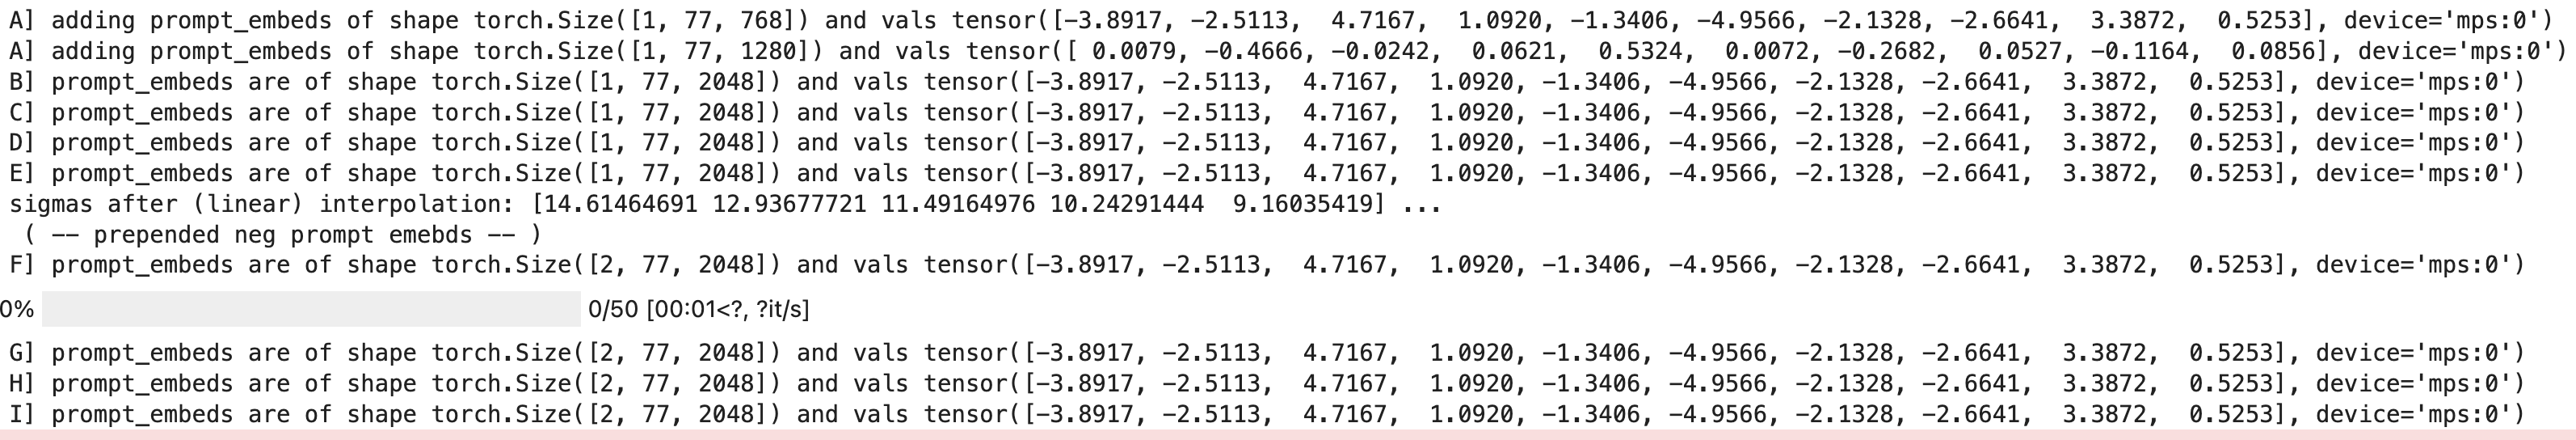

Okay, let's not use the encoders piece-by-piece, but in one go

In [51]:
my_full_encoder_1 = cnxs_pipe.text_encoder
my_full_encoder_2 = cnxs_pipe.text_encoder_2

In [52]:
my_enc_output_1_via_full = my_full_encoder_1(my_toks_1, output_hidden_states=True).hidden_states[-2]
my_enc_output_2_via_full = my_full_encoder_2(my_toks_2, output_hidden_states=True).hidden_states[-2]

In [53]:
my_enc_output_1_via_full.shape, my_enc_output_2_via_full.shape

(torch.Size([1, 77, 768]), torch.Size([1, 77, 1280]))

In [54]:
print(my_enc_output_1_via_full.flatten()[:10])

tensor([-3.892, -2.511,  4.717,  1.092, -1.341, -4.957, -2.133, -2.664,  3.387,  0.525], device='cuda:0', grad_fn=<SliceBackward0>)


Okay, that's the same.

This means I don't fully understand yet how the encoders work internally.

**Q:** Why is the manually computed text embedding different from the automatically computed one, even on the same device (here: local)?

In [55]:
def encode(prompt, tokenizer, text_encoder, use_casual_attn_mask):    
        text_input_ids = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).input_ids.to(device)

        prompt_embeds = forward_of_CLIPTextModelWithProjection(text_encoder, text_input_ids, use_casual_attn_mask)

        return prompt_embeds['hidden_states'][-2]
        
def forward_of_CLIPTextModelWithProjection(self, input_ids, use_casual_attn_mask):
    text_outputs = forward_of_CLIPTextTransformer(self.text_model,input_ids=input_ids,use_casual_attn_mask=use_casual_attn_mask)

    return dict(
        text_embeds="boring text_embeds",
        last_hidden_state=text_outputs['last_hidden_state'],
        hidden_states=text_outputs['hidden_states'],
    )

def forward_of_CLIPTextTransformer(self, input_ids,use_casual_attn_mask):
    input_shape = input_ids.size()
    input_ids = input_ids.view(-1, input_shape[-1])

    hidden_states = self.embeddings(input_ids=input_ids, position_ids=None)
    
    if use_casual_attn_mask:
        # CLIP's text model uses causal mask, prepare it here.
        # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324
        causal_attention_mask = _create_4d_causal_attention_mask(
            input_shape, hidden_states.dtype, device=hidden_states.device
        )
    else:
        causal_attention_mask = None
        
    encoder_outputs = self.encoder(
        inputs_embeds=hidden_states,
        attention_mask=None,
        causal_attention_mask=causal_attention_mask,
        output_attentions=None,
        output_hidden_states=True,
        return_dict=True,
    )

    return dict(
        last_hidden_state="Bleh",
        pooler_output="Blah",
        hidden_states=encoder_outputs['hidden_states'],
    )

from transformers.modeling_attn_mask_utils import AttentionMaskConverter
def _create_4d_causal_attention_mask(
    input_shape,
    dtype, device,
    past_key_values_length = 0,
    sliding_window = None,
):
    """
    Creates a causal 4D mask of shape `(batch_size, 1, query_length, key_value_length)`
    """
    attn_mask_converter = AttentionMaskConverter(is_causal=True, sliding_window=sliding_window)

    key_value_length = past_key_values_length + input_shape[-1]
    attention_mask = attn_mask_converter.to_causal_4d(
        input_shape[0], input_shape[-1], key_value_length, dtype=dtype, device=device
    )

    return attention_mask

In [56]:
encode(prompt, cnxs_pipe.tokenizer, cnxs_pipe.text_encoder, use_casual_attn_mask=False).flatten()

tensor([-1.316, -1.622,  0.167,  ...,  0.164, -0.174, -0.127], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [57]:
encode(prompt, cnxs_pipe.tokenizer, cnxs_pipe.text_encoder, use_casual_attn_mask=True).flatten()

tensor([-3.892, -2.511,  4.717,  ..., -1.205, -0.858, -0.195], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

**A:** My mistake was I didn't use casual attention mask.

In [58]:
my_casual_attn_mask = _create_4d_causal_attention_mask([1, 77], torch.float32, 'cuda')

In [59]:
my_casual_attn_mask.shape

torch.Size([1, 1, 77, 77])

In [60]:
import matplotlib.pyplot as plt

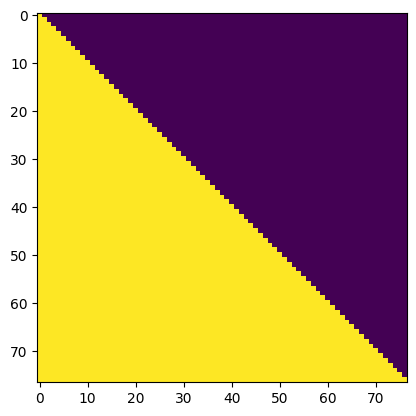

In [61]:
plt.imshow(my_casual_attn_mask[0,0].cpu().detach())

Okay, I managed to reproduce the text encoding manually, so I understand them. Let's comapre them now across local (cuda diffusers) and cloud (cuda Heidelberg)

Okay, I want to save these intermediate results:
- text emb
- pos emb
- text+pos emb
- all hidden states

In [62]:
def encode_get_all_hidden_states(prompt, tokenizer, text_encoder):
        text_input_ids = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).input_ids.to(device)

        prompt_embeds = forward_of_CLIPTextModelWithProjection(text_encoder, text_input_ids, use_casual_attn_mask=True)

        return prompt_embeds['hidden_states']

intermediates_1 = encode_get_all_hidden_states(prompt, cnxs_pipe.tokenizer, cnxs_pipe.text_encoder)
intermediates_2 = encode_get_all_hidden_states(prompt, cnxs_pipe.tokenizer_2, cnxs_pipe.text_encoder_2)

In [63]:
intermediates_1[0].shape, intermediates_2[0].shape

(torch.Size([1, 77, 768]), torch.Size([1, 77, 1280]))

In [64]:
import pickle
with open('intermediate_output/text emb/local_1.pkl', 'wb') as f: pickle.dump(intermediates_1, f)
with open('intermediate_output/text emb/local_2.pkl', 'wb') as f: pickle.dump(intermediates_2, f)

___

Let's load the encoded texts from from Heidelberg.<br/>
Remember: They use mixed precision training (via autocast), which results in the ~ `0.0005` difference. I have turned that off, so these are the 'manually' computed Heidelberg text-encoder outputs.<br>
Thy should be exactly equal to the diffuers text-encoder outputs.

In [66]:
enc_txt_1_c = torch.load('intermediate_output/text emb/cloud_1.pt')
enc_txt_2_c = torch.load('intermediate_output/text emb/cloud_2.pt')

In [67]:
enc_txt_1_l = intermediates_1[-2]
enc_txt_2_l = intermediates_2[-2]

In [75]:
(enc_txt_1_c==enc_txt_1_l).all().item(), (enc_txt_2_c==enc_txt_2_l).all().item()

(True, False)

In [78]:
torch.set_printoptions(precision=5, sci_mode=False)
(enc_txt_1_c-enc_txt_1_l).abs().mean(), (enc_txt_2_c-enc_txt_2_l).abs().mean()

(tensor(0., device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(    0.00000, device='cuda:0', grad_fn=<MeanBackward0>))

In [73]:
enc_txt_2_c

tensor([[[ 0.008, -0.467, -0.024,  ...,  0.190,  0.418, -0.297],
         [-0.423, -0.342,  0.448,  ...,  0.050,  0.212, -0.273],
         [ 0.197,  0.535,  0.106,  ...,  0.165,  0.424,  0.004],
         ...,
         [ 0.005, -0.687,  0.603,  ..., -0.200,  0.554,  0.535],
         [-0.103, -0.564,  0.499,  ..., -0.318,  0.350,  0.453],
         [ 0.043, -0.152,  0.356,  ..., -0.120,  0.237,  0.206]]], device='cuda:0')

In [72]:
enc_txt_2_l

tensor([[[ 0.008, -0.467, -0.024,  ...,  0.190,  0.418, -0.297],
         [-0.423, -0.342,  0.448,  ...,  0.050,  0.212, -0.273],
         [ 0.197,  0.535,  0.106,  ...,  0.165,  0.424,  0.004],
         ...,
         [ 0.005, -0.687,  0.603,  ..., -0.200,  0.554,  0.535],
         [-0.103, -0.564,  0.499,  ..., -0.318,  0.350,  0.453],
         [ 0.043, -0.152,  0.356,  ..., -0.120,  0.237,  0.206]]], device='cuda:0', grad_fn=<AddBackward0>)

## Result:

The difference in text encodings between cuda diffusers and cuda Heidelberg is split in 2 parts:
1. `cuda diffusers` and `cuda Heidelberg w/o mixed precision`: **no** difference; exactly equal
2. `cuda diffusers w/o mixed precision` and `cuda Heidelberg w/ mixed precision`: **all** the difference, ie ~ `0.0005`